### Purpose:
 - Download retrospective hourly analysis & assimilation NWM files from the Google Cloud archive
 - Obtain and plot the discharge time series of a stream of interest
 - Run the cells in order to import libraries, select parameters, define functions, download files, and plot a discharge series
    
### Inputs:
 - (1) begin date for data retrieval
 - (2) end date for data retrieval (inclusive)
 - (3) desired product (channel routing or forcing)
 - (4) directory for downloaded files

In [1]:
# import python libraries

import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import sys
import xarray as xr

from matplotlib.dates import DateFormatter
from time import sleep


In [2]:
# select input parameters

begindate = "20190915"  # data is avail. beginning 20180917
enddate = "20190930"  # inclusive
product = "channel_rt"  # 'channel_rt' or 'forcing'
destfolder_name = "test"  # directory will be created in current working directory if it does not already exist


In [3]:
# define functions


def get_netcdf(filetype, begin_date, end_date, output_folder_name):

    output_folder = os.path.join(os.getcwd(), output_folder_name)

    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    if filetype == "channel_rt":
        prodstr = ""
    elif filetype == "forcing":
        prodstr = "forcing_"
    else:
        print("Product error. Choose 'channel_rt' or 'forcing'.")
        sys.exit()

    t1 = pd.to_datetime(begin_date)
    t2 = pd.to_datetime(end_date)
    dates = pd.date_range(t1, t2)

    for i in range(len(dates)):
        date = dates[i]
        save_dir = date.strftime("%Y%m%d")

        if not os.path.exists(output_folder + "/" + save_dir):
            os.mkdir(output_folder + "/" + save_dir)

        for hr in range(24):

            url = (
                f"https://storage.googleapis.com/national-water-model/"
                f'nwm.{date.strftime("%Y%m%d")}/{prodstr}analysis_assim/'
                f"nwm.t{str(hr).zfill(2)}z.analysis_assim.{filetype}.tm00.conus.nc"
            )

            filename = os.path.basename(url)
            write_file = os.path.join(output_folder, save_dir, filename)

            for attempt in range(30):
                try:
                    r = requests.get(url)
                    with open(write_file, "wb") as f:
                        f.write(r.content)
                    break
                except Exception as ex:
                    if attempt != max_attempts - 1:
                        sleep(0.5)  # Give NOAA time to wake up
                    else:
                        m = "Could not download file.\n" + str(ex)
                        raise Exception(m)

        print(f"{save_dir} done")


def get_series(comid, begin_date, end_date, datafolder_name, filetype):

    data_folder = os.path.join(os.getcwd(), datafolder_name)

    t1 = pd.to_datetime(begin_date)
    t2 = pd.to_datetime(end_date)
    dates = pd.date_range(t1, t2)

    df = pd.DataFrame()

    for i in range(len(dates)):
        date = dates[i]
        date_dir = date.strftime("%Y%m%d")

        for hr in range(24):
            filename = f"nwm.t{str(hr).zfill(2)}z.analysis_assim.{filetype}.tm00.conus.nc"
            nc_file = os.path.join(data_folder, date_dir, filename)
            data = xr.open_dataset(nc_file)
            Q = float(data.sel(feature_id=comid).streamflow.values)
            # time given in "minutes since 1970-01-01 00:00:00 UTC"
            tdval = data.sel(feature_id=comid).time.values
            td = pd.Timedelta(minutes=td)
            timestamp = pd.to_datetime("1970-01-01 00:00:00 UTC") + td
            df.loc[timestamp, "Q"] = Q

    return df


In [4]:
# download files

get_netcdf(product, begindate, enddate, destfolder_name)


20190915 done
20190916 done
20190917 done
20190918 done
20190919 done
20190920 done
20190921 done
20190922 done
20190923 done
20190924 done
20190925 done
20190926 done
20190927 done
20190928 done
20190929 done
20190930 done


In [5]:
# extract a discharge time series for an individual stream from the downloaded files
# this example shows a reach of the Sabine River in Southeast Texas during TS Imelda
# compare: https://nwis.waterdata.usgs.gov/nwis/uv?cb_00060=on&cb_00065=on&format=gif_default&site_no=08030500&period=&begin_date=2019-09-15&end_date=2019-09-30

comid = 8331880  # Sabine river near USGS gage 08030500
sabine_timeseries_df = get_series(
    comid, begindate, enddate, destfolder_name, product
)


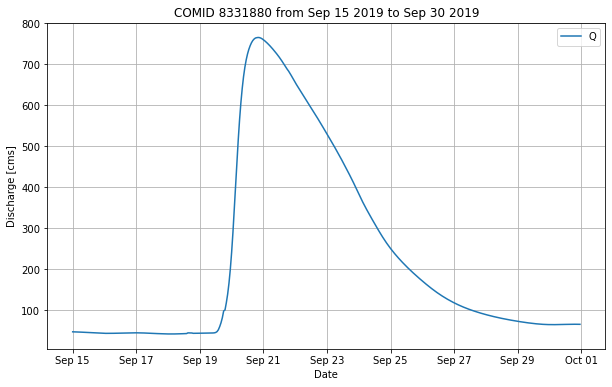

In [6]:
# plot the discharge time series

plt.rc("font", size=14)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sabine_timeseries_df, color="tab:blue", label="Q")
ax.set(
    xlabel="Date",
    ylabel="Discharge [cms]",
    title=f"COMID {comid} from "
    f'{pd.to_datetime(begindate).strftime("%b %d %Y")} to '
    f'{pd.to_datetime(enddate).strftime("%b %d %Y")}',
)
date_form = DateFormatter("%b %d")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.grid(True)
